## Libraries

In [3]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
# import plotly.express as px

## Constants

In [4]:
file_path = "mpu6050_data_0_to_90.csv" 
filtered_file_path = "mpu6050_filtered_kalman.csv"
output_file = "mpu6050_filtered_adaptive.csv"

## Loading the data

In [5]:
df = pd.read_csv(file_path)
df

,timestamp,yaw,pitch,roll,ax,ay,az
0,0.039793,0.00,-0.11,1.62,-310,7374,-6322
1,0.072700,0.00,-0.16,2.60,-422,7064,-6293
2,0.118896,0.01,-0.20,3.55,-502,6676,-6266
3,0.159533,0.02,-0.24,4.48,-373,6503,-6212
4,0.199684,0.02,-0.29,5.39,-416,6191,-6301
...,...,...,...,...,...,...,...
245,9.844164,-93.64,-0.24,32.88,-232,-2123,-3681
246,9.885775,-93.63,-0.27,32.91,-166,-2210,-3707
247,9.926478,-93.63,-0.30,32.94,-255,-2074,-3622
248,9.966486,-93.63,-0.32,32.97,-103,-2148,-3625


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  250 non-null    float64
 1   yaw        250 non-null    float64
 2   pitch      250 non-null    float64
 3   roll       250 non-null    float64
 4   ax         250 non-null    int64  
 5   ay         250 non-null    int64  
 6   az         250 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 13.8 KB


## Basic Statistics

In [7]:
df.drop("timestamp", axis=1).describe()

,yaw,pitch,roll,ax,ay,az
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,-51.886400,4.526920,25.379440,-1556.928000,319.536000,-4337.552000
std,46.001509,8.128932,8.696578,2152.303382,2373.021809,762.596315
min,-98.940000,-1.680000,1.620000,-7993.000000,-2790.000000,-6322.000000
25%,-93.897500,-1.247500,20.230000,-2409.250000,-1569.250000,-4832.500000
50%,-93.630000,0.425000,28.550000,-416.500000,-581.500000,-4183.500000
75%,0.427500,7.412500,32.190000,-59.500000,1734.500000,-3766.250000
max,0.940000,26.650000,35.540000,239.000000,7374.000000,-2628.000000


In [8]:
columns_to_filter = df.columns.to_list()[1:]
columns_to_filter

['yaw', 'pitch', 'roll', 'ax', 'ay', 'az']

## Kalman Filter

In [9]:
def kalman_filter(z, Q=1e-5, R=0.01, initial_value=None):
    n_iter = len(z)
    xhat = np.zeros(n_iter)      
    P = 1.0                      

    if initial_value is None:
        xhat[0] = z[0]
    else:
        xhat[0] = initial_value

    for k in range(1, n_iter):
        xhatminus = xhat[k-1]
        Pminus = P + Q

        K = Pminus / (Pminus + R)
        xhat[k] = xhatminus + K * (z[k] - xhatminus)
        P = (1 - K) * Pminus

    return xhat

In [10]:
filtered_kalman_df = df.copy()
for col in columns_to_filter:
    filtered_kalman_df[col] = kalman_filter(df[col].values, Q=1e-5, R=0.01)


filtered_kalman_df.to_csv(filtered_file_path, index=False)

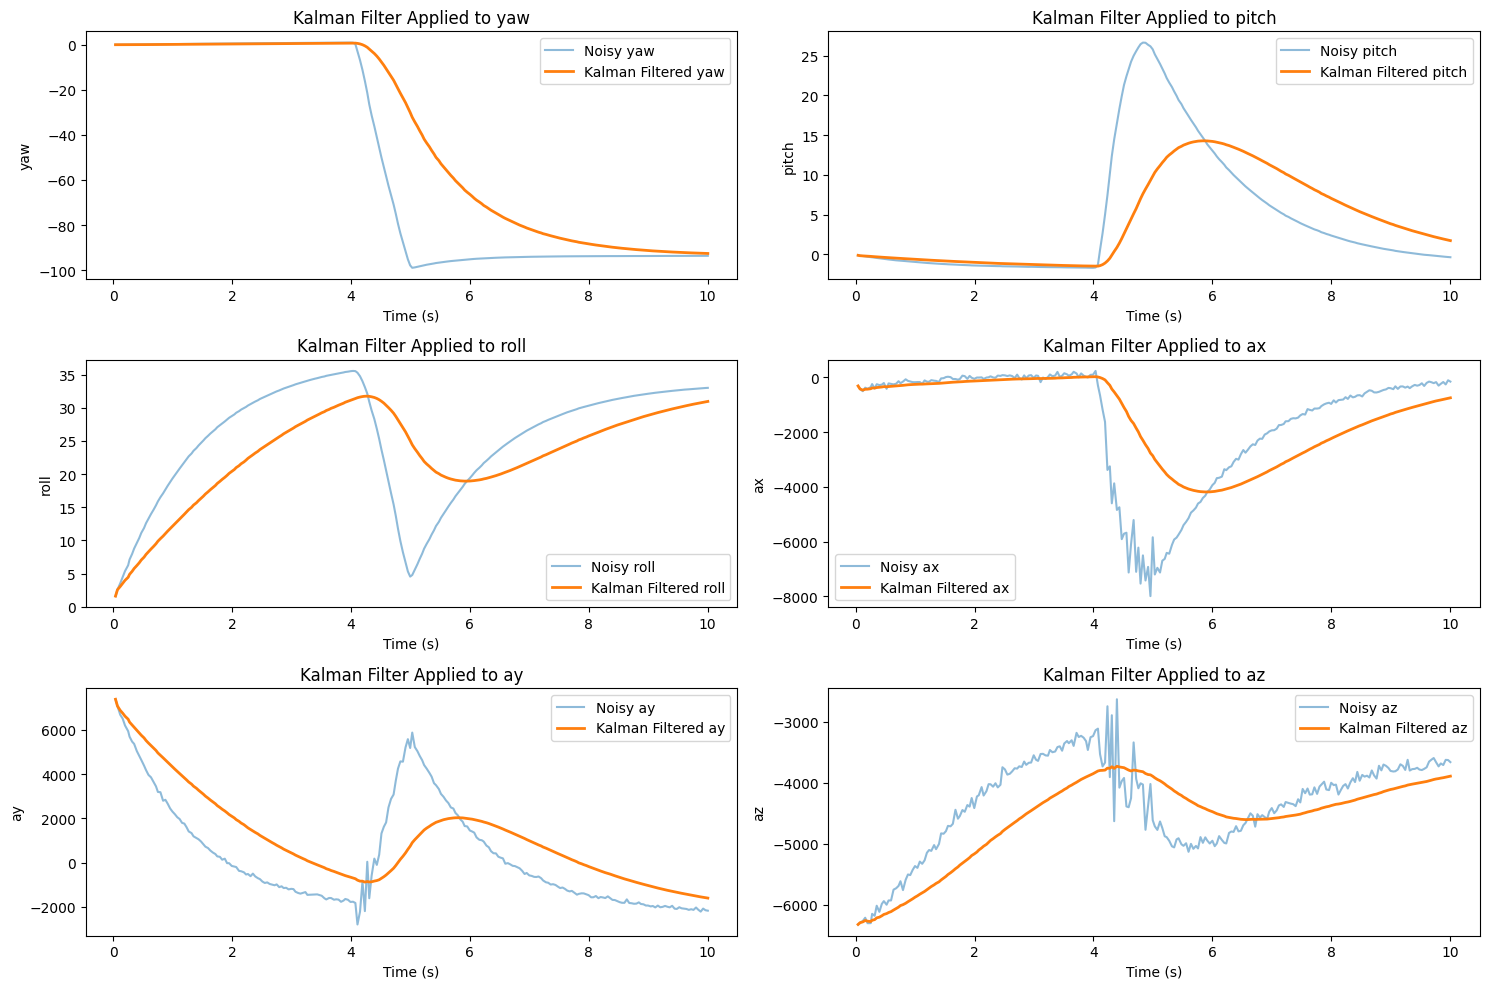

In [11]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_to_filter):
    plt.subplot(3, 2, i+1)
    plt.plot(df["timestamp"], df[col], label=f"Noisy {col}", alpha=0.5)
    plt.plot(filtered_kalman_df["timestamp"], filtered_kalman_df[col], label=f"Kalman Filtered {col}", linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel(col)
    plt.legend()
    plt.title(f"Kalman Filter Applied to {col}")


plt.tight_layout()
plt.show()


## Another Approach

In [12]:
def apply_median_filter(data, kernel_size=3):
    return signal.medfilt(data, kernel_size=kernel_size)


In [13]:
median_filtered_df = df.copy()
for col in columns_to_filter:
    median_filtered_df[col] = apply_median_filter(df[col].values, kernel_size=3)

## Adaptive kalman filter

In [14]:
def adaptive_kalman_filter(z, Q=1e-5, R=0.01, threshold_factor=3, initial_value=None):
    n_iter = len(z)
    xhat = np.zeros(n_iter)
    P = 1.0                   

    xhat[0] = z[0] if initial_value is None else initial_value
    
    robust_std = np.std(z)
    
    for k in range(1, n_iter):
        xhatminus = xhat[k-1]
        Pminus = P + Q

        innovation = z[k] - xhatminus

        if abs(innovation) > threshold_factor * robust_std:
            adaptive_R = R * 10  
        else:
            adaptive_R = R

        K = Pminus / (Pminus + adaptive_R)
        
        xhat[k] = xhatminus + K * innovation
        
        P = (1 - K) * Pminus

    return xhat

In [15]:
robust_filtered_df = df.copy()
for col in columns_to_filter:
    robust_filtered_df[col] = adaptive_kalman_filter(median_filtered_df[col].values,
                                                            Q=1e-5, R=0.01, threshold_factor=3)

robust_filtered_df.to_csv(output_file, index=False)

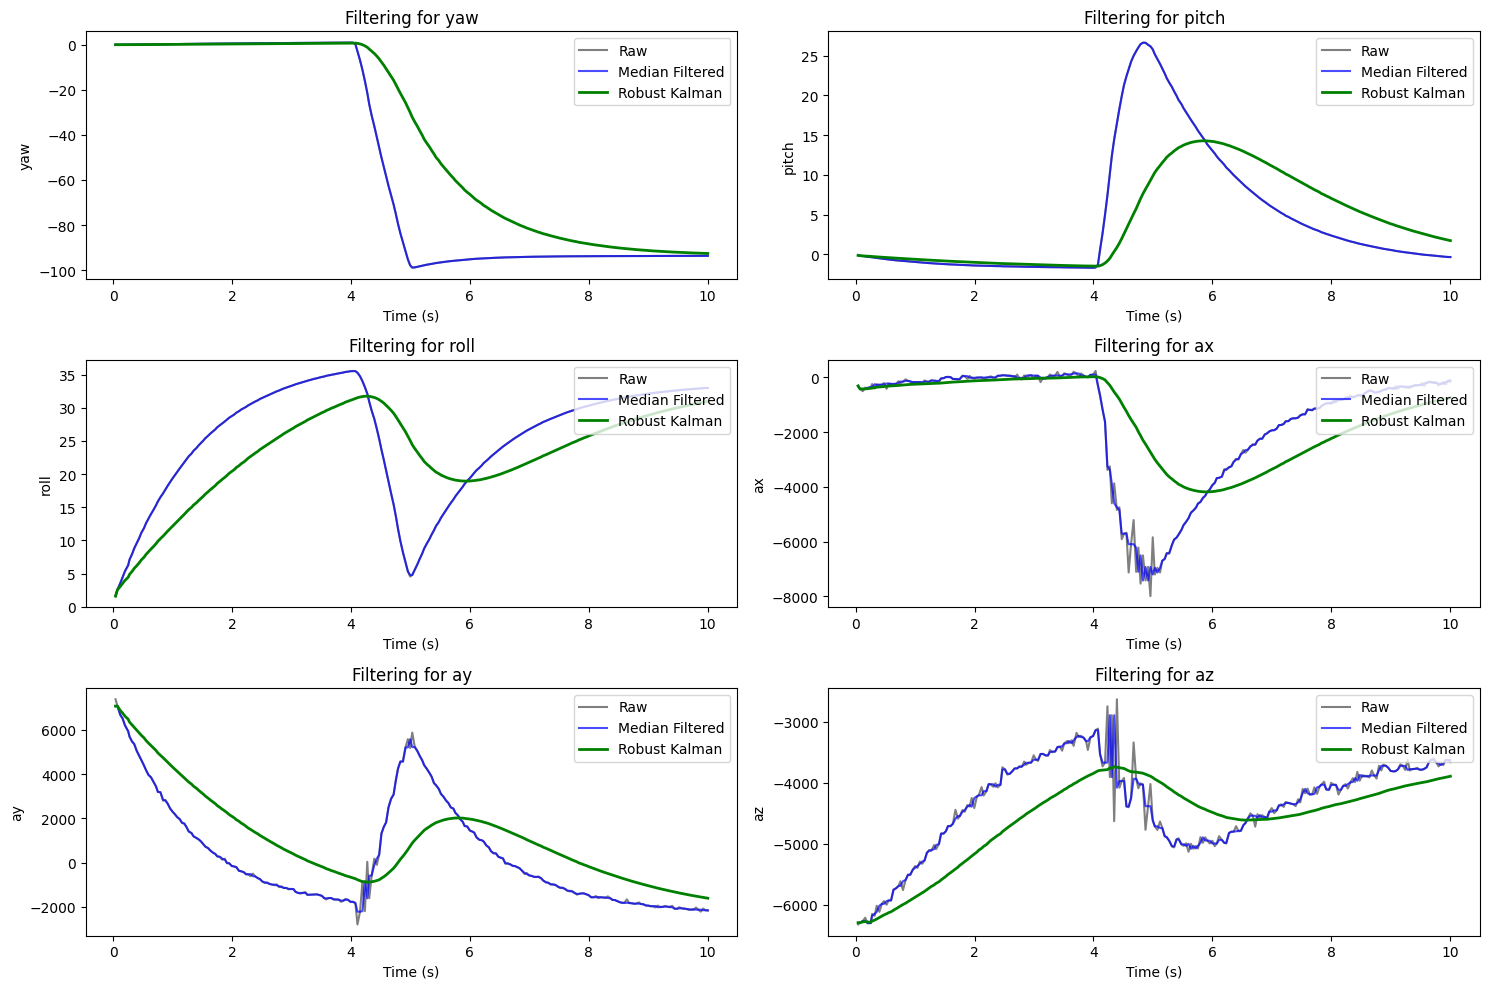

In [16]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_to_filter):
    plt.subplot(3, 2, i+1)
    plt.plot(df["timestamp"], df[col], label="Raw", alpha=0.5, c='black')
    plt.plot(median_filtered_df["timestamp"], median_filtered_df[col], label="Median Filtered", alpha=0.7, c='b')
    plt.plot(robust_filtered_df["timestamp"], robust_filtered_df[col], label="Robust Kalman", linewidth=2, c='g')
    plt.xlabel("Time (s)")
    plt.ylabel(col)
    plt.legend(loc='upper right')
    plt.title(f"Filtering for {col}")

plt.tight_layout()
plt.show()

In [17]:
# for col in columns_to_filter:
#     fig = px.line(df, x="timestamp", y=col, labels={"timestamp": "Time (s)", col: "Value"}, title=f"Filtering for {col}")

#     fig.add_scatter(x=median_filtered_df["timestamp"], y=median_filtered_df[col], mode="lines",
#                     name="Median Filtered", line=dict(color="blue", width=1))

#     fig.add_scatter(x=robust_filtered_df["timestamp"], y=robust_filtered_df[col], mode="lines",
#                     name="Robust Kalman", line=dict(color="green", width=2))

#     fig.add_scatter(x=df["timestamp"], y=df[col], mode="lines",
#                     name="Raw", line=dict(color="black", width=1, dash="dot"))

#     fig.show()
